In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import time
%matplotlib inline 

#TODO : CHANGE ACCORDING TO NEEDS
imported_data=True # True if data/... already exists
evaluation=True # True if want to evaluate error of machine learning algo
submit=True # True if want to replace submission file by new values

In [3]:
#Import data if not already done
if (not imported_data) : 
    import ImportData

In [4]:
# BEGINNING OF LEARNING CODE
# Read submission data
submission = pd.read_csv('submission.txt', sep='\t')

# Stock list of services to predict
ass_list=submission['ASS_ASSIGNMENT'].unique()

# Imports data into dictionary
data = {}
for x in ass_list : 
    data[x] = np.load('data/'+x+'.npy')

In [5]:
#Adding features

# add_features() changes structure of data[x] where x is a service name :
# date (timestamp) / number of calls / day of week / month / time
# time is from 0 to 47 (hour*2+minutes/30)
def add_features(): 
    print("Features added for : ")
    for x in ass_list :
        # Initialize two columns of zero
        n=np.shape(data[x])[0]
        z=np.zeros((n,3),int) 
        
        # Append zero column twice
        data[x]=np.append(data[x],z,axis=1)

        # Addding Columns : Day of week / Month
        for i in range(n) :
            data[x][i,2]=pd.to_datetime(data[x][i,0]).weekday()
            data[x][i,3]=data[x][i,0].month
            data[x][i,4]=int((2*data[x][i,0].hour)+(data[x][i,0].minute/30))
            
        if (x!='Prestataires') : 
            print(x, end=", ")
        else : 
            print(x)
        # TODO IMPROVE
        # - possibly much faster if adding features in dataframe
        # - Label Binarizer - change magnitude of day of week, month, hour
        #                     to 7, 31, 48 columns of 0 and 1s respectively
        
# del_features deletes everything from column 2
def del_features():
    for x in ass_list :
        data[x]=np.delete(data[x],np.s_[2:np.shape(data[x])[1]],1)
        
del_features()
add_features()
print(data[ass_list[0]][::1000,:])

Features added for : 
CMS, Crises, Domicile, Gestion, Gestion - Accueil Telephonique, Gestion Assurances, Gestion Relation Clienteles, Gestion Renault, Japon, Médical, Nuit, RENAULT, Regulation Medicale, SAP, Services, Tech. Axa, Tech. Inter, Téléphonie, Tech. Total, Mécanicien, CAT, Manager, Gestion Clients, Gestion DZ, RTC, Prestataires
[[Timestamp('2011-01-03 08:00:00') 0 0 1 16]
 [Timestamp('2011-02-22 06:00:00') 0 1 2 12]
 [Timestamp('2011-04-29 15:00:00') 0 4 4 30]
 [Timestamp('2011-07-05 09:00:00') 0 1 7 18]
 [Timestamp('2011-08-25 18:00:00') 0 3 8 36]
 [Timestamp('2011-10-20 10:00:00') 0 3 10 20]
 [Timestamp('2011-12-13 13:30:00') 0 1 12 27]
 [Timestamp('2012-02-13 14:30:00') 0 0 2 29]
 [Timestamp('2012-04-05 15:30:00') 0 3 4 31]
 [Timestamp('2012-06-04 12:30:00') 0 0 6 25]
 [Timestamp('2012-08-01 09:30:00') 0 2 8 19]
 [Timestamp('2012-09-21 19:30:00') 0 4 9 39]
 [Timestamp('2012-11-16 15:30:00') 0 4 11 31]
 [Timestamp('2012-12-24 00:30:00') 0 0 12 1]
 [Timestamp('2013-02-15 06

In [6]:
df={}
for x in ass_list : 
    df[x]=pd.DataFrame.from_dict(data[x])
    df[x].columns=['DATETIME','CALLS','DAY','MONTH','TIME']

In [24]:
# data is ambient dictionary in this script

# predict_single_week takes in "dates" which is a list of timestamps (continuous)
# Assume dates given in groups of weeks, take minimum of dates. 
# predict_single_week returns a dictionary predicted where:
# keys = services, values = numpy arrays (TimeStamp, Calls Received)

def predict_single_week(dates) : 
    # Initialize and clear dictionary to return
    predicted={}
    predicted.clear()

    # X and Y restocks df as information needed to predict and calls, until min date
    
    # Assume dates given in groups of weeks, take minimum of dates. 
    min_date = min(dates)
    X={}
    Y={}
    est={}
    
    for x in ass_list : 
        X[x]=df[x][['DAY','MONTH','TIME']][df[x]['DATETIME']<pd.to_datetime(min_date)].as_matrix()
        Y[x]=df[x]['CALLS'][df[x]['DATETIME']<pd.to_datetime(min_date)].as_matrix()
        
    
    
    # Method of learning
    from sklearn.ensemble import GradientBoostingRegressor
    
    # Creating each predictor
    for x in ass_list : 
        clf=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0, loss='ls')
        est[x] = clf.fit(X[x], Y[x])

    
    
    # Creating X_test from dates that has all information needed
    X_test=np.zeros((len(dates),3),int)

    for i in range(len(dates)) :
        X_test[i,0]=dates[i].weekday()
        X_test[i,1]=dates[i].month
        X_test[i,2]=int((2*dates[i].hour)+(dates[i].minute/30))

    # Calculating y_test for each predictor
    y_test={}
    for x in ass_list : 
        #y_test[x]=est[x].predict(X_test)
        # Round up always
        y_test[x]=np.ceil(est[x].predict(X_test)).astype(int)
        # Make sure all positive
        y_test[x]=y_test[x]*(y_test[x]>0)
        predicted[x]=np.append(np.reshape(dates,(len(dates),1)),np.reshape(y_test[x],(len(dates),1)),axis=1)
    
    return predicted

In [ ]:
# Function dates_to_datetime creates datetime stamps at every half hour from a list of date
def dates_to_datetime(dates) : 
    datetimes=[]
    times=["00:00:00.000", "00:30:00.000", "01:00:00.000", "01:30:00.000", 
           "02:00:00.000", "02:30:00.000", "03:00:00.000", "03:30:00.000", 
           "04:00:00.000", "04:30:00.000", "05:00:00.000", "05:30:00.000", 
           "06:00:00.000", "06:30:00.000", "07:00:00.000", "07:30:00.000", 
           "08:00:00.000", "08:30:00.000", "09:00:00.000", "09:30:00.000", 
           "10:00:00.000", "10:30:00.000", "11:00:00.000", "11:30:00.000", 
           "12:00:00.000", "12:30:00.000", "13:00:00.000", "13:30:00.000", 
           "14:00:00.000", "14:30:00.000", "15:00:00.000", "15:30:00.000", 
           "16:00:00.000", "16:30:00.000", "17:00:00.000", "17:30:00.000", 
           "18:00:00.000", "18:30:00.000", "19:00:00.000", "19:30:00.000", 
           "20:00:00.000", "20:30:00.000", "21:00:00.000", "21:30:00.000", 
           "22:00:00.000", "22:30:00.000", "23:00:00.000", "23:30:00.000"]
    for date in dates : 
        for time in times : 
            datetime_entry=str(date+' '+time)
            datetimes.append(datetime.strptime(datetime_entry, "%Y-%m-%d %H:%M:%S.%f"),)
    return datetimes

# Split list of dates into list of (weeks=list of datetimes)
def dates_to_weeks(dates):
    weeks=[]
    week=[]
    current_wk=0

    for date in dates : 
        if (len(week)==0) :
            week.append(datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f"))

        elif (len(week)==14*48):
            weeks.append(week)
            week=[]

        else : 
            current_wk = week[-1].isocalendar()[:2]

            if (current_wk[1]==52) :
                next_wk=(current_wk[0]+1,1)
            else : 
                next_wk=(current_wk[0],current_wk[1]+1)


            if ((datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f").isocalendar()[:2]==current_wk)or(datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f").isocalendar()[:2]==next_wk)) :
                week.append(datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f"))
            else :
                weeks.append(week)
                week=[]
    return weeks


# Error function as defined in project
def linex(y_true,y_pred) : 
    a=0.1
    assert(len(y_true)==len(y_pred))
    diff=np.subtract(y_true,y_pred)
    return np.exp(a*diff)-a*diff-np.ones(len(y_true))

In [ ]:
# Predict for each week in list, append all predicted
def predict(dates) : 
    weeks=dates_to_weeks(dates)
    predicted={}

    for week in weeks : 
        print("Predicting : ", end='')
        print(week[-1].isocalendar()[:2])
        predicted_week=predict_single_week(week)

        for x in ass_list : 
            if (x in predicted) :
                predicted[x]=np.concatenate((predicted[x], predicted_week[x]), axis=0)
            else :
                predicted[x]=predicted_week[x]

    return predicted

In [ ]:
#EVALUATION
if (evaluation) : 
    # EXAMPLE DATE
    dates = ['2011-12-28', '2011-12-29', '2011-12-30', '2011-12-31', '2012-01-01', '2012-01-02', '2012-01-03']
    fulldates=dates_to_datetime(dates) #with timestamps, for predict function
    
    # Call predict
    predicted=predict(fulldates)

    # Dictionaries for true and predicted values
    y_true={}
    y_pred={}
    y_true.clear()
    y_pred.clear()
    err={}
    err.clear()
    err_tot=0
    len_tot=0
    
    # Stocking and printing error by service where there is data
    for x in ass_list : 
        y_true[x]=[]
        y_pred[x]=[]
        print("Evaluating error for : "+x)
        for t in fulldates : # for date
            for i in range(len(data[x])) : 
                if (data[x][i,0]==t) : # if date found in original data
                    y_true[x].append(data[x][i,1])
                    for j in range(len(predicted[x])) : #find date in predicted
                        if (str(predicted[x][j,0])==str(t)) : 
                            y_pred[x].append(predicted[x][j,1])
                            break # add predicted one time
                    break # add original one time
        err[x]=linex(y_true[x],y_pred[x])
        err_tot+=np.sum(err[x])
        len_tot+=len(err[x])
        #print("vector error : ")
        #print(err[x])
        print("error : ")
        print(np.sum(err[x]))
        print()
    print("total error : ")
    print(err_tot)

CMS


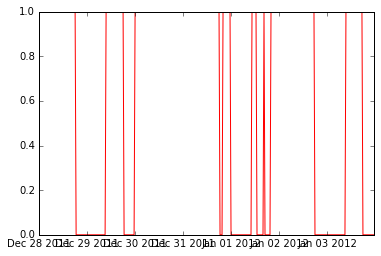

Crises


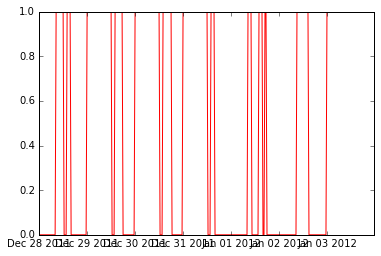

Domicile


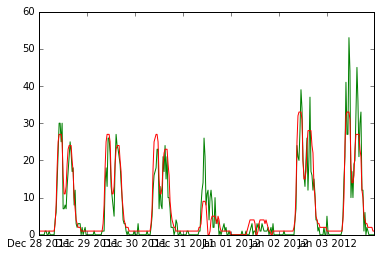

Gestion


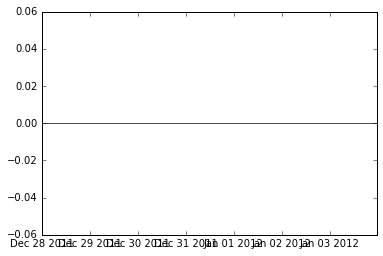

Gestion - Accueil Telephonique


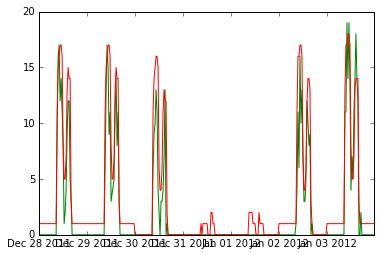

Gestion Assurances


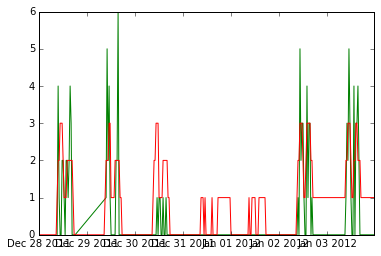

Gestion Relation Clienteles


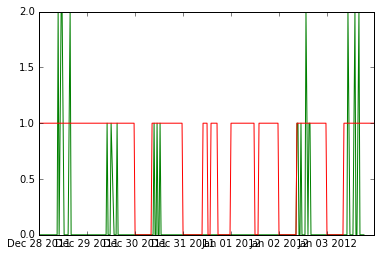

Gestion Renault


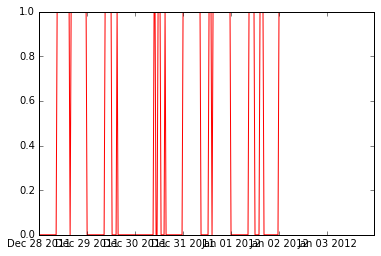

Japon


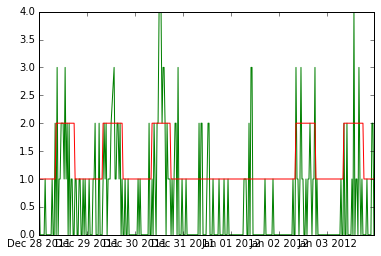

Médical


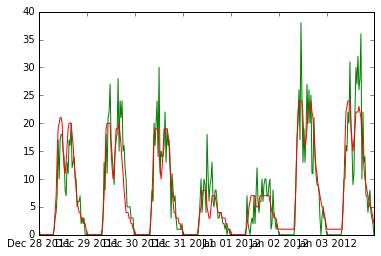

Nuit


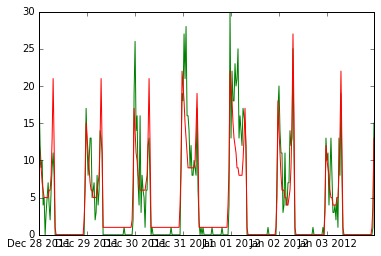

RENAULT


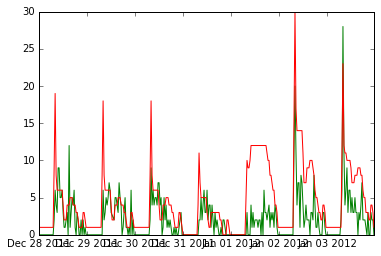

Regulation Medicale


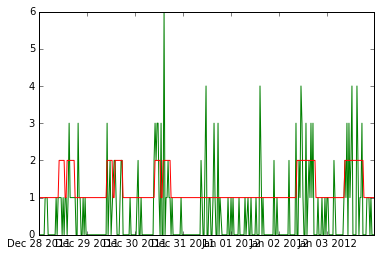

SAP


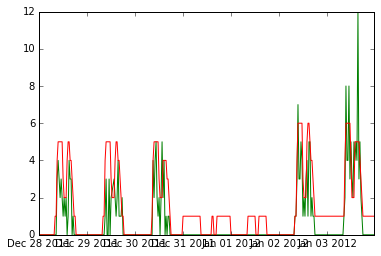

Services


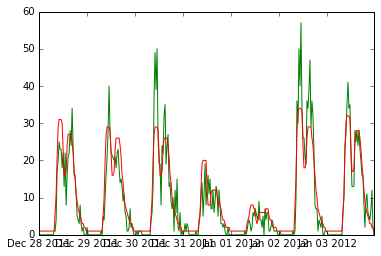

Tech. Axa


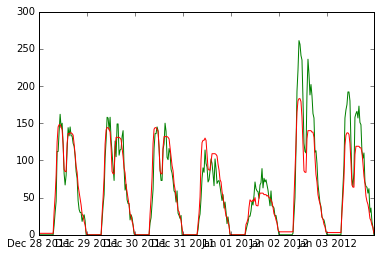

Tech. Inter


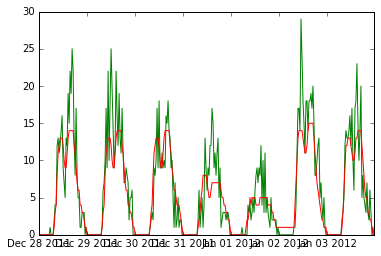

Téléphonie


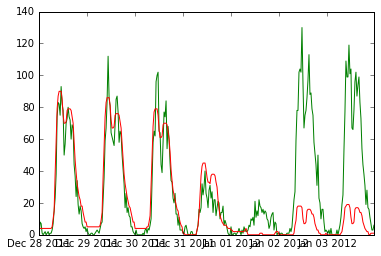

Tech. Total


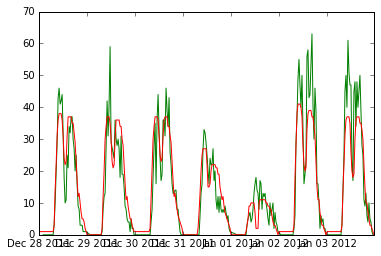

Mécanicien


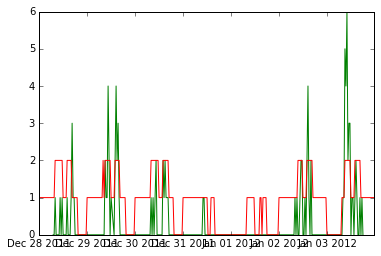

CAT


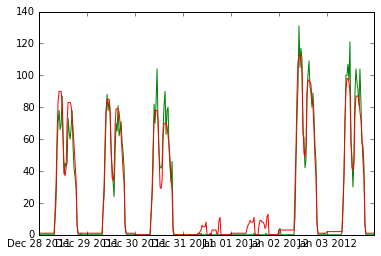

Manager


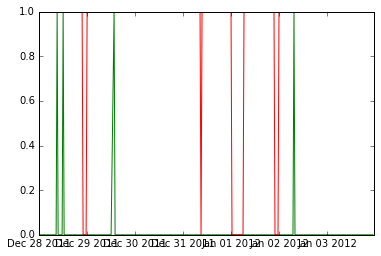

Gestion Clients


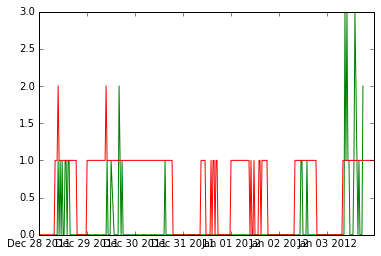

Gestion DZ


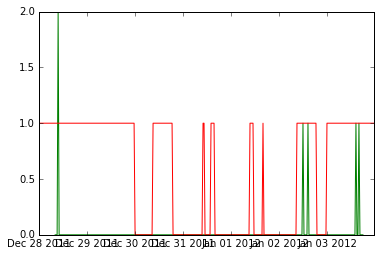

RTC


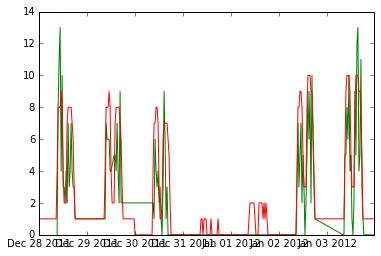

Prestataires


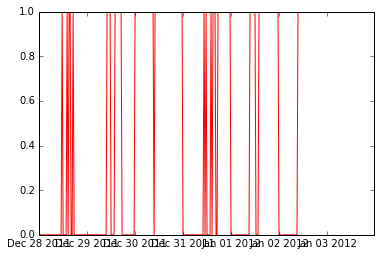

In [30]:
# Visualization of original vs predicted for evaluation range
if (evaluation):
    df2={}
    mean={}

    for x in ass_list : 
        print(x)
        #Original is green
        df2[x]=df[x][['DATETIME','CALLS']][df[x]['DATETIME'].isin(predicted[x][:,0])].as_matrix()
        plt.plot(df2[x][:,0],df2[x][:,1],'g')

        #Predicted is red
        plt.plot(predicted[x][:,0],predicted[x][:,1],'r')

        #Mean is blue
        #mean[x]=[]
        #for i in range(48) : # For each hour
        #     mean[x]=np.append(mean[x],(df[x]['CALLS'][df[x]['TIME']==i].mean()))
        #mean[x]=np.tile(mean[x],len(predicted[x][:,0])/48)

        #plt.plot(predicted[x][:,0],mean[x],'b')
        plt.show()

In [ ]:
# UPDATE SUBMISSIONS.TXT
# ASS_ASSIGNMENT : because not every service appears at any time, 
# have to check values exist in submissions.txt that we received,
# we cannot construct new dataframe directly from predicted

if (submit) : 
    # List of dates in submission.txt
    dates=submission['DATE'].unique()
    
    # Call predict function on weeks
    predicted=predict(dates)
    
    #Rewrite submissions dataframe
    for x in ass_list : 
        print("Stocking predictions for "+x)
        if (x in predicted) : # x=assignment
            for row in predicted[x] : # row=[date,calls]
                # Convert timestamp to yyyy-mm-dd hh:mm:ss.xxx
                date = row[0].strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]
                # Replace values in submission dsataframe
                #better way to loop through this?
                submission.loc[(submission['DATE']==date)&(submission['ASS_ASSIGNMENT']==x), ['prediction']]=row[1]

    # EXPORT to submission.txt 
    fh = open("submission1.txt","w")
    fh.write("DATE\tASS_ASSIGNMENT\tprediction")
    for index, row in submission.iterrows(): 
        fh.write("\n")
        fh.write(str(row[0])+'\t'+str(row[1])+'\t'+str(row[2]))
    fh.close()
    print("Text file written!")

Predicting : (2013, 1)
Predicting : (2013, 6)
Predicting : (2013, 11)
Predicting : (2013, 16)
Predicting : (2013, 20)
Predicting : (2013, 25)
Predicting : (2013, 30)
Predicting : (2013, 34)
Predicting : (2013, 38)
Predicting : (2013, 43)
Predicting : (2013, 48)
Stocking predictions for CMS
Stocking predictions for Crises
Stocking predictions for Domicile
Stocking predictions for Gestion
Stocking predictions for Gestion - Accueil Telephonique
Stocking predictions for Gestion Assurances
Stocking predictions for Gestion Relation Clienteles
Stocking predictions for Gestion Renault
Stocking predictions for Japon
Stocking predictions for Médical
Stocking predictions for Nuit
Stocking predictions for RENAULT
Stocking predictions for Regulation Medicale
Stocking predictions for SAP
Stocking predictions for Services
Stocking predictions for Tech. Axa
Stocking predictions for Tech. Inter
Stocking predictions for Téléphonie
Stocking predictions for Tech. Total
Stocking predictions for Mécanicien
